# Set up

### Imports

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import librosa
import matplotlib.pyplot as plt    
import numpy as np
import pandas as pd 
import seaborn as sns

#import librosa.display
#import matplotlib   
#import IPython.display as ipd
#from scipy.io import wavfile

from scipy import signal
from scipy.stats import norm, kurtosis
from scipy.signal import welch
from scipy.integrate import simps

#import scipy 

import operator #Used to sort 
import glob #
import json
from datetime import datetime

import statistics

##import warnings
##warnings.filterwarnings('ignore')
%matplotlib inline

from tqdm import tqdm

from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb


from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [4]:
df_paths = pd.read_csv("/content/gdrive/MyDrive/Masteroppgave/wav_paths_master.csv") 
df_paths['mic'] = df_paths['mic'].str.replace("l", "").str.replace("m", "").apply(pd.to_numeric) #Removes 'm' and 'l' from mic and casts it to int 
#df_paths["filename"] = df_paths.path.str.replace('/content/gdrive/MyDrive/Masteroppgave/IDMT_dataset', '')

#df_presaved = pd.read_csv("/content/gdrive/MyDrive/Masteroppgave/preloaded_files_csv/combined_csv.csv") 
#df_files = pd.merge(df_presaved, df_paths, on="filename", how="inner")
#df_files.drop(columns=["index", "filename"], inplace=True)


# Functions

## Helper functions 

In [5]:
def join_meta(df_meta, df_input):
  df = df_input.join(df_meta)
  df.index.name = "index"
  return df

In [6]:
from scipy.signal import butter, lfilter, filtfilt, sosfilt

def butter_highpass(cutoff, fs, order=9):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=9):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [7]:
def pre_save_files(df_input, cutoff=0, save_path=None, sr=None):
  df_files = pd.DataFrame()
  
  for ind in tqdm(df_input.index):
    y, sample_rate = librosa.load(df_input['path'][ind], sr=None)
    if type(cutoff) == int and cutoff > 0: 
      y = butter_highpass_filter(y, cutoff, sample_rate,order=4)
    df_file = pd.DataFrame({"samples": [y], "sr": sample_rate})
    df_files = pd.concat([df_files, df_file], join = 'outer', axis = 0)
  df_files.index = df_input.index
  
  if save_path:
    df_files.to_json(save_path)


  return df_files



In [8]:
def preprocesses(X,T,normalize=True):
  if normalize:
    scaler = MinMaxScaler()
    scaler = scaler.fit(X)
    X_scaled = pd.DataFrame(scaler.transform(X))
    X_scaled.columns = X.columns
    T_scaled = pd.DataFrame(scaler.transform(T))
    T_scaled.columns = T.columns

  return X_scaled, T_scaled 


In [9]:
def make_list(split_list): #[0,10000,1000]
  split = split_list.copy()
  split[1] = split[1]+split[-1]
  splitted_list =  np.arange(split[0], split[1], split[2]).tolist()
  return splitted_list

In [10]:
def invert_preds(preds):
  return np.abs(preds-1)

def get_accuracy(pred, gt):
  score = 0 
  if len(pred) != len(gt):
    return
  for i in range(len(pred)):
    if pred[i] == gt[i]:
      score+=1

  accuracy = np.round(score/len(pred),4)

  if accuracy < 0.1:
    accuracy=1-accuracy

  return accuracy

In [11]:
def get_wanted_files(df, wanted_files):
    for key in wanted_files:
        if wanted_files[key]:
            df = df.loc[(df[key].isin(wanted_files[key]))]
    return df 


In [12]:
def add_white_noise(signal,noise_factor):
  noise = np.random.normal(0,signal.std(),signal.size)
  augmented_signal = signal + noise * noise_factor
  return augmented_signal

def random_gain(signal, min_gain_factor, max_gain_factor):
  gain_factor = np.random.uniform(min_gain_factor, max_gain_factor)
  return signal * gain_factor

In [13]:
def bandpower(data, sf, band_list, window_sec=None, relative=False, reduce_split=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """


    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = 0.3 * sf

    # Compute the modified periodogram (Welch)
    #win = scipy.signal.get_window('hanning',nperseg)
    freqs, psd = welch(data, sf, nperseg=nperseg)
    
    avg_band_power = []

    #Kan vurdere å bruke matplotlib sin psd 
    ##win = matplotlib.mlab.window_hanning(np.ones(nperseg)) # or
    ##psd, freqs = matplotlib.mlab.psd(data, Fs=sf,window=win)



    # Frequency resolution
    for i in range(len(band_list)-1):
      freq_res = freqs[1] - freqs[0]
      low = band_list[i]
      high = band_list[i+1]

      # Find closest indices of band in frequency vector
      idx_band = np.logical_and(freqs >= low, freqs <= high)

      # Integral approximation of the spectrum using Simpson's rule.
      bp = simps(psd[idx_band], dx=freq_res)


      if relative:
          bp /= simps(psd, dx=freq_res)

      
      avg_band_power.append(bp)


    if reduce_split:
      reduced = []  
      for i in range(len(reduce_split)-1):
        s = avg_band_power[reduce_split[i]:reduce_split[i+1]]
        reduced.append(sum(s))
      return pd.DataFrame([reduced])

    return pd.DataFrame([avg_band_power])

In [14]:
def plot_learning_curve(estimator, title, X, y,cv=None, n_jobs=None,train_sizes=np.linspace(0.1, 1.0, 5),):
  plt.figure(figsize=(8,5))
  train_sizes, train_scores, test_scores = learning_curve(estimator,X,y)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)
  plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",)
  plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")


  plt.fill_between(
      train_sizes,
      test_scores_mean - test_scores_std,
      test_scores_mean + test_scores_std,
      alpha=0.1,
      color="g",)
  plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")

  plt.legend(loc="best")
  plt.title(title)
  plt.show()

In [15]:
def plot_corr_matrix(df_features):
  # run correlation matrix and plot
  f, ax = plt.subplots(figsize=(10, 8))
  corr = df_features.corr()
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
              cmap=sns.diverging_palette(220, 10, as_cmap=True),
              square=True, ax=ax)

## Feature functions

In [16]:
#Kan hende denne kan slettes? 
def get_bandpower_dataframe(df_input,window_sec, split_list, reduce_split=False):
  df = pd.DataFrame()

  if split_list[0] == "even": 
    band_list = make_list(split_list)
  else: 
    band_list = split_list[0]
  
  for ind in tqdm(df_input.index):
    signal, sr = np.array(df_input["samples"][ind]), df_input["sr"][ind]
    bin_power = bandpower(signal, sr, band_list ,window_sec=window_sec, relative=True, reduce_split=reduce_split)
    df = pd.concat([df,bin_power],axis=0,ignore_index=True)
  
  df.index = df_input.index
  names = [str("rp_bin: " + str(i)) for i in range(len(np.array(df.columns)))]
  df.columns = names

  return df

"""
Split_list is what frequency segements the file should be devidied into, while reduce split combines several segments by summing between the elements in the list
A unneccesery way of doing it but I like that I still can get the firste version without reduced split
"""
#df_rel_pwr_train = get_bandpower_dataframe(df_train.head(), window_sec=10, split_list=[0, 24000, 1000])
#df_rel_pwr_train = get_bandpower_dataframe(df_train.head(), window_sec=10, split_list=[0, 24000, 1000], reduce_split=[0,6,13,-1])
#df_rel_pwr_train


'\nSplit_list is what frequency segements the file should be devidied into, while reduce split combines several segments by summing between the elements in the list\nA unneccesery way of doing it but I like that I still can get the firste version without reduced split\n'

In [17]:
def get_data_labels(df_train_features, df_test_features, drop_features=None):

  df_train_features_drop = df_train_features.drop(columns=['Unnamed: 0','feature_index', 'index','samples','sr','path','leak_type','knob_rotations','environment','recording','mic'],errors='ignore')
  df_test_features_drop = df_test_features.drop(columns=['Unnamed: 0','feature_index','index','samples','sr','path','leak_type','knob_rotations','environment','recording','mic'],errors='ignore')


  y = df_train_features_drop['leak_present'].values
  X = df_train_features_drop.drop(columns=['leak_present'])
  if drop_features: 
    X = X.drop(columns=drop_features)

  gt = df_test_features_drop['leak_present'].values
  T = df_test_features_drop.drop(columns=['leak_present'])
  if drop_features: 
    T = T.drop(columns=drop_features)



  return X,y,T,gt


## Feature Extraction

In [18]:
def get_train_test_dataframes_presaved(df, train_files, test_files, verbose):    
    df_train = get_wanted_files(df, train_files)
    df_test = get_wanted_files(df, test_files)

    if verbose: 
        print(str(np.round(df_train["leak_present"].mean(),2)*100) + " % label distribution")
        print(df_train["leak_present"].value_counts())
        print(str(np.round(df_test["leak_present"].mean(),2)*100) + " % label distribution")
        print(df_test["leak_present"].value_counts())
        
    return df_train, df_test


In [19]:
def get_train_test_dataframes(df, train_files, test_files, cutoff=0, verbose=0):    
    df_train = get_wanted_files(df, train_files)
    df_test = get_wanted_files(df, test_files)

    df_train_loaded = pre_save_files(df_train, cutoff=cutoff)
    df_test_loaded = pre_save_files(df_test, cutoff=cutoff)

    df_train = join_meta(df_train_loaded, df_train)
    df_test = join_meta(df_test_loaded, df_test)

    if verbose: 
        print(str(np.round(df_train["leak_present"].mean(),2)*100) + " % label distribution")
        print(df_train["leak_present"].value_counts())
        print(str(np.round(df_test["leak_present"].mean(),2)*100) + " % label distribution")
        print(df_test["leak_present"].value_counts())
        
    return df_train, df_test



In [20]:
def get_train_test_features(df_train, df_test, use_features, split_list, win_len, log_rel_pwr, shuffle):

  print("> making train features")
  df_train_features = get_all_features(df_train, use_features, split_list, win_len,log_rel_pwr=False) 
  df_train_features = df_train_features.loc[:, ~df_train_features.columns.duplicated()]
  df_train_features = df_train_features.join(df_train, on="feature_index", how="left")
  print("")

  
  print("> making test features")
  df_test_features = get_all_features(df_test,use_features, split_list, win_len,log_rel_pwr=False) 
  df_test_features = df_test_features.loc[:, ~df_test_features.columns.duplicated()]
  df_test_features = df_test_features.join(df_test, on="feature_index",how="left")
  print("")




  if log_rel_pwr:
    #x_norm, t_norm = preprocesses(df_train_features.filter(regex='rp_bin'), df_test_features.filter(regex='rp_bin'))
    x_norm, t_norm = df_train_features.filter(regex='rp_bin'), df_test_features.filter(regex='rp_bin')

    x_norm_log = np.log(x_norm) #Can test log10, log2 as well
    t_norm_log = np.log(t_norm)    
    df_train_features.loc[x_norm_log.index.isin(df_train_features.index), x_norm_log.columns.values] = x_norm_log[x_norm_log.columns.values]
    df_test_features.loc[t_norm_log.index.isin(df_test_features.index), t_norm_log.columns.values] = t_norm_log[t_norm_log.columns.values]

  if shuffle: 
    df_train_features = shuffle(df_train_features)
    df_test_features = shuffle(df_test_features)


  return df_train_features, df_test_features


In [21]:
def get_all_features(df, use_features, split_list, win_len=0.3, log_rel_pwr=False):

  if "time-freq" in use_features: 
    print("time-frequency features")
    df_freq = get_time_freq_feature_dataframe(df, win_len=win_len)
  else: 
    df_freq = pd.DataFrame()

  if "rel-pwr" in use_features: 
    print("relative power features")
    #df_relative_pwr = get_bandpower_dataframe(df, window_sec=10, split_list=[0, 24000, 2500])
    df_relative_pwr = get_bandpower_dataframe_framed(df,win_len=win_len, window_sec=1, split_list=split_list)
    #df_relative_pwr = get_bandpower_dataframe(df, window_sec=10, split_list=[0, 24000, 1000], reduce_split=[0,6,13,-1]) #This reduce split means: from 0-6kHz, 6-13kHz, and 13kHz to the end
    #if log_rel_pwr: 
    #  df_relative_pwr = np.log10(df_relative_pwr)
    print("done!")
  else: 
    df_relative_pwr = pd.DataFrame()



  #df_all_features = df_freq.join(df_relative_pwr, on="index")
  df_freq.reset_index(inplace=True)
  df_relative_pwr.reset_index(inplace=True)
  
  df_all_features = pd.concat([df_freq,df_relative_pwr],axis=1)

  df_all_features.columns = df_all_features.columns.astype(str)

  #df_all_features.index = df
  return df_all_features 
  

In [22]:
def get_time_freq_feature_dataframe(df_input, win_len):
  FRAME_LENGTH = int((win_len * 48000)) #48000 is the expected sample rate
  HOP_LENGTH = FRAME_LENGTH // 2 #50% overlap

  features = []

  for ind in tqdm(df_input.index):
    #feature_list = freq_domain_features(np.array(df_input["samples"][ind]), df_input["sr"][ind], ind, win_len=win_len)

    feature_list_time = time_domain_features(df_input["samples"][ind],df_input["sr"][ind], win_len=win_len, return_empty=True)
    #feature_list_freq = freq_domain_features(df_input["samples"][ind],df_input["sr"][ind], ind, win_len=win_len)
    #feature_list_freq = freq_domain_features_V2(df_input["samples"][ind],df_input["sr"][ind], ind, win_len=win_len)
    feature_list_freq = freq_domain_features_V3(df_input["samples"][ind],df_input["sr"][ind], ind, FRAME_LENGTH=FRAME_LENGTH,HOP_LENGTH=HOP_LENGTH)

    feature_list = pd.concat([feature_list_time, feature_list_freq], join = 'outer', axis = 1)
    
    features.append(feature_list)

  df = pd.concat(features, ignore_index=True)


  return df


In [23]:
def time_domain_features(signal, sr, win_len, return_empty=False):
  if return_empty:
    return pd.DataFrame()
    
  mean = []
  max = []
  std = []
  kurt = []
  skew = []
  #rms = []
  crest_factor = []
  PPV = []


  FRAME_LENGTH = int(sr * win_len)
  HOP_LENGTH = FRAME_LENGTH//2

  frames = librosa.util.frame(signal, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH).T #Overlappen skal komme fra hop_length her som er 50%
  #print(frames.shape)
  for frame in frames: 
    mean.append(np.mean(frame))
    max.append(np.max(np.abs(frame)))
    std.append(np.std(frame))
    
    #rms.append(compute_rms(frame))
    #crest_factor.append(np.max(np.abs(frame)) / compute_rms(frame))



  features = [mean, std, max]
  names = ["mean", "std", "max"]


  dft = pd.DataFrame(features).T

  dft.columns = names
  return dft


In [24]:
def freq_domain_features_V2(signal, sr, index, win_len=1, no_panda=False,):
  
  FRAME_LENGTH = sr * 5
  HOP_LENGTH = sr #FRAME_LENGTH
  rmse=librosa.feature.rms(y=signal,frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
  spec_cent = librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)
  spec_bw = librosa.feature.spectral_bandwidth(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)
  rolloff = librosa.feature.spectral_rolloff(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)
  zcr = librosa.feature.zero_crossing_rate(y=signal,frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH, )
  mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH)
  spec_contrast = (librosa.feature.spectral_contrast(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH))  

  features = [np.mean(rmse), np.mean(spec_cent), np.mean(spec_bw), np.mean(rolloff), np.mean(zcr)]
  for e in mfcc:
    features.append(np.mean(e))
  
  for c in spec_contrast:
    features.append(np.mean(c))

  df = pd.DataFrame(features).T
  df["feature_index"] = [index]
  #df.index.name = "feature_index"
  return df
  

In [25]:
from scipy.stats import kurtosis, skew

def freq_domain_features_V3(signal, sr, index, FRAME_LENGTH,HOP_LENGTH, no_panda=False,):

  #FRAME_LENGTH = int(sr * win_len)
  #HOP_LENGTH = FRAME_LENGTH//2
  
  frames = librosa.util.frame(signal, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH).T #Overlappen skal komme fra hop_length her som er 50%

  #RETURNS 2D FEATURE LIST 
  #spec_contrast = (librosa.feature.spectral_contrast(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0]).T
  spec_contrast = (librosa.feature.spectral_contrast(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, center=False))#.mean(axis=0)  
  df_contrast = pd.DataFrame(spec_contrast).T
  names_contrast = [str("cont_bin: " + str(i)) for i in range(len(np.array(df_contrast.columns)))]
  df_contrast.columns = names_contrast
  
  mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, center=False)
  df_mfcc = pd.DataFrame(mfcc).T
  names_mfcc = [str("mfcc_bin: " + str(i)) for i in range(len(np.array(df_mfcc.columns)))]
  df_mfcc.columns = names_mfcc
  
  #RETURNS 1D FEAUTRE LIST 
  zcr = librosa.feature.zero_crossing_rate(y=signal,frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH,center=False)[0]
  rmse=librosa.feature.rms(y=signal,frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH,center=False)[0]
  spec_centroid = (librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0])
  spec_bandwidth = (librosa.feature.spectral_bandwidth(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0])
  spec_flatness = (librosa.feature.spectral_flatness(y=signal, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0])
  spec_rolloff = (librosa.feature.spectral_rolloff(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH,center=False)[0])
  #S, phase = librosa.magphase(librosa.stft(signal,n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False))

  flat_features = [spec_centroid, spec_bandwidth, spec_flatness, zcr, rmse] 
  flat_names = ["spec_centroid", "spec_bandwidth", "spec_flatness", "zcr", "rmse"]
  df_flat = pd.DataFrame(flat_features).T
  df_flat.columns = flat_names 

  df = pd.concat([df_flat,df_contrast,df_mfcc],axis=1)
  index_col = (np.ones(len(frames))*index)
  #df["feature_index"] = index_col
  df.insert(0, "feature_index", index_col)

  return df

In [26]:
from scipy.stats import kurtosis, skew

def freq_domain_features(signal, sr, index, win_len=1, no_panda=False,):
  peak_freq = []
  peak_freq_amp = []

  FRAME_LENGTH = int(sr * win_len)
  HOP_LENGTH = FRAME_LENGTH//2
  
  
  frames = librosa.util.frame(signal, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH).T #Overlappen skal komme fra hop_length her som er 50%


  #for frame in frames: 
  #  peak_freq.append((n_max_freq_amp(1,frame, sr)[0])[0])
  #  peak_freq_amp.append((n_max_freq_amp(1,frame, sr)[1])[0])

  #RETURNS 2D FEATURE LIST 
  #spec_contrast = (librosa.feature.spectral_contrast(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0]).T
  spec_contrast = (librosa.feature.spectral_contrast(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, center=False))#.mean(axis=0)  
  df_contrast = pd.DataFrame(spec_contrast).T
  names_contrast = [str("cont_bin: " + str(i)) for i in range(len(np.array(df_contrast.columns)))]
  df_contrast.columns = names_contrast
  
  #RETURNS 1D FEAUTRE LIST 
  spec_centroid = (librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0])
  spec_bandwidth = (librosa.feature.spectral_bandwidth(y=signal, sr=sr, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0])
  spec_flatness = (librosa.feature.spectral_flatness(y=signal, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0])
  #spec_rolloff = (librosa.feature.spectral_rolloff(y=signal, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False)[0])
  #S, phase = librosa.magphase(librosa.stft(signal,n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH, win_length=FRAME_LENGTH,center=False))
  #spec_rms = (librosa.feature.rms(S=S, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH, center=False)[0]).T

  flat_features = [spec_centroid, spec_bandwidth, spec_flatness] 
  flat_names = ["spec_centroid", "spec_bandwidth", "spec_flatness"]


  index_col = (np.ones(len(frames))*index)
  flat_features += [index_col]
  flat_names += ["feature_index"]

  df_flat = pd.DataFrame(flat_features).T
  df_flat.columns = flat_names 

  df = pd.concat([df_contrast,df_flat],axis=1)

  return df

In [27]:

def get_bandpower_dataframe_framed(df_input, win_len, window_sec, split_list, reduce_split=False):
  df = pd.DataFrame()


  band_list = make_list(split_list)
  #band_list = [0,1000,10000,15000,20000,24000]

  #for ind in tqdm(df_input.index):
  for ind in (df_input.index):

    df_signal = pd.DataFrame()

    signal, sr = np.array(df_input["samples"][ind]), df_input["sr"][ind]

    #win_len = librosa.get_duration(y=signal, sr=sr)//2
    FRAME_LENGTH = int(sr * win_len)
    HOP_LENGTH = FRAME_LENGTH//2
    frames = librosa.util.frame(signal, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH).T 
    
    for frame in frames:
      bin_power = bandpower(frame, sr, band_list ,window_sec=window_sec, relative=True, reduce_split=reduce_split)
      bin_power['index'] = [float(ind)]
      
      df_signal = pd.concat([df_signal,bin_power],axis=0)
    
    df = pd.concat([df,df_signal],axis=0,)

  names = [str("rp_bin: " + str(i)) for i in range(len(np.array(df.columns)))]
  df.columns = names
  df.columns = [*df.columns[:-1], 'feature_index']

  return df

#get_bandpower_dataframe_framed(df.head(5), win_len=10, window_sec=1, split_list=[0, 24000, 2500])

## ML functions

In [28]:
def plot_model_learning_curves(trained_models, train_data, labels):
  for model in trained_models:
    plot_learning_curve(trained_models[model], model, train_data, labels )
  return 

def plot_feature_importance(trained_models,train_data):
      features = train_data.columns
      for model in trained_models:
        try: 
          tree_feature_importances = trained_models[model].feature_importances_
          indices = np.argsort(tree_feature_importances)
          plt.figure(figsize=(15,10)) 
          plt.title(model + ' Feature Importances')
          plt.barh(range(len(indices)), tree_feature_importances[indices], align='center')
          plt.yticks(range(len(indices)), [features[i] for i in indices])
          plt.xlabel('Relative Importance')
        except:
          plt.close()
        #plt.show()

def plot_decsion_tree(trained_models, train_data):
  fn = train_data.columns.values
  cn=['no_leak', 'leak']
  model = "dt"
  #Text tree representation
  print("Text representation of decision tree: ")
  print("")
  print(tree.export_text(trained_models[model],decimals=4))
  print("")

  #Plot three representation
  fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=150)
  tree.plot_tree(trained_models[model],
                feature_names = fn, 
                class_names=cn,
                precision=4,
                filled = True)
  plt.title("Visual representation of decision tree")
  plt.show()

def plot_confusion_matricies(trained_models, test_data, test_label):
  for model in trained_models:
      try:
        fig, ax = plt.subplots(figsize=(10,10))
        plt.title(model + " confusion matrix")
        disp = ConfusionMatrixDisplay.from_estimator(
            trained_models[model],
            test_data,
            test_label,
            display_labels=[0,1],
            cmap=plt.cm.Blues,
            normalize=None,
            ax=ax) 
      except:
        plt.close()

In [29]:
def plot_model_information(trained_models,train_data,train_labels, test_data, test_labels, tree_plot, learning_curves, feature_importance, confusion_matrix):
  if tree_plot:
    plot_decsion_tree(trained_models, train_data)
  if learning_curves:
    plot_model_learning_curves(trained_models,train_data,train_labels)
  if feature_importance:
    plot_feature_importance(trained_models,train_data)
  if confusion_matrix:
    plot_confusion_matricies(trained_models, test_data,test_labels)



In [30]:
def store_files_and_score(scores, train_files, test_files,features, save_path):
  now = datetime.now()
  dt_string = now.strftime("%d/%m/%Y %H:%M:%S") #Setting the key to current time 

  one_run = {
      dt_string : {
        "scores":scores,
        "train_files":train_files,
        "test_files":test_files,
        "features":features,
        }
      }

  if save_path:
    try: 
      with open(save_path, "r+") as file: #If file excists we append the results
        data = json.load(file)
        data.update(one_run)
        file.seek(0)
        json.dump(data, file,indent=5)
    except: #Has to create the file if it does not excist 
      with open(save_path, "w") as file:
        json.dump(one_run, file,indent=5)

  else: 
    return 

In [31]:
def read_run_plan(run_plan_path):
  with open(run_plan_path, 'r') as f:
    return json.load(f)


In [32]:
def run_several_tests_recording_split(df_paths, run_plan, save_path, print_scores=True):
    prev_train_files = None
    prev_test_files = None
    prev_features = None
    prev_df_train = None
    prev_df_test = None 

    for run in run_plan:
        print("working on run: " + str(run))
        train_files = run_plan[run]["train_files"] #Important that these names are used in the run_plan file 
        test_files = run_plan[run]["test_files"]
        features = run_plan[run]["features"]

        if train_files == prev_train_files and test_files == prev_test_files: #If they are the same as before we don't create them again
          print("these are the same as last run, so reuse them")
          df_train, df_test = prev_df_train, prev_df_test
        else: 
          print("not the same as last run, create new")
          df_train, df_test = get_train_test_dataframes(df_paths, train_files, test_files, verbose=False)

        df_train_features, df_test_features = get_train_test_features(df_train, df_test, split_list = features['split_list'], win_len=features['win_len'], log_rel_pwr=features['log_rel_pwr'], shuffle=features['shuffle'])
        
        stored_scores = train_test_with_record_split(df_train_features, df_test_features)
        
        #X, y, T, gt = get_data_labels(df_train_features, df_test_features)

        #trained_models = train_ml_models(X,y)
        #scores = predict_ml_models(trained_models,T,gt)
        
        if print_scores: 
          print(scores)
          print("----")

        store_files_and_score(stored_scores, train_files, test_files,features, save_path = save_path)
        
        prev_df_train, prev_df_test = df_train, df_test
        prev_train_files, prev_test_files = train_files, test_files

    return

In [33]:
def run_several_tests(df_paths, run_plan, save_path, print_scores=True):
    prev_train_files = None
    prev_test_files = None
    prev_features = None
    prev_df_train = None
    prev_df_test = None 

    for run in run_plan:
        print("working on run: " + str(run))
        train_files = run_plan[run]["train_files"] #Important that these names are used in the run_plan file 
        test_files = run_plan[run]["test_files"]
        features = run_plan[run]["features"]

        if train_files == prev_train_files and test_files == prev_test_files: #If they are the same as before we don't create them again
          print("these are the same as last run, so reuse them")
          df_train, df_test = prev_df_train, prev_df_test
        else: 
          print("not the same as last run, create new")
          df_train, df_test = get_train_test_dataframes(df_paths, train_files, test_files, verbose=False)

        df_train_features, df_test_features = get_train_test_features(df_train, df_test, win_len=features['win_len'], log_rel_pwr=features['log_rel_pwr'], shuffle=features['shuffle'])
        X, y, T, gt = get_data_labels(df_train_features, df_test_features)

        trained_models = train_ml_models(X,y)
        scores = predict_ml_models(trained_models,T,gt)
        
        if print_scores: 
          print(scores)
          print("----")

        store_files_and_score(scores, train_files, test_files,features, save_path = "stored_files_and_score.json")
        
        prev_df_train, prev_df_test = df_train, df_test
        prev_train_files, prev_test_files = train_files, test_files

    return

In [34]:
def get_classification_report(trained_models, test_data, test_labels):
  for model in trained_models: 
    preds = trained_models[model].predict(test_data)
    print("Model name: " + model.upper())
    print(classification_report(test_labels, preds))



In [35]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

def predict_ml_models(trained_models, data, labels):
    scores = {}
    true_pred_sums = {}
    f1_scores = {}
    recalls = {}
    precisions = {}



    for model in trained_models:
        predictions = trained_models[model].predict(data) 
        score = trained_models[model].score(data,labels) 
        true_preds = np.sum(predictions)/len(predictions)
        f1 = f1_score(labels, predictions, average='macro')
        recall = recall_score(labels, predictions)
        precision = precision_score(labels, predictions)

        if model == "km": #Kmeans has no score method 
          score = get_accuracy(trained_models[model].predict(data), labels)
        scores[model] = score
        true_pred_sums[model] = true_preds
        f1_scores[model] = f1
        recalls[model] = recall
        precisions[model] = precision



        


    sorted_scores = dict(sorted(scores.items(), key=operator.itemgetter(1),reverse=True))

    return sorted_scores, true_pred_sums, f1_scores, recalls, precisions 

In [36]:
def train_test_recordwise(df_train_features, df_test_features):
  recs_train = df_train_features.recording.unique()
  recs_test = df_test_features.recording.unique()
  if (len(recs_train) - len(recs_test)) != 0: 
    print("No")
    return None
    
  dfs = []
  for rec in recs_test: 
    df_test_features_rec = df_test_features.loc[df_test_features['recording'] == rec] 
    df_train_features_rec = df_train_features.loc[df_train_features['recording'] != rec] 
    dfs.append([df_train_features_rec,df_test_features_rec])
  
  return dfs

def train_test_with_record_split(df_train_features, df_test_features,normalize,reduced_features):
  record_splitted_dfs = train_test_recordwise(df_train_features, df_test_features)
  score_storage = []
  f1_storage = []


  for record_split in record_splitted_dfs:
    X, y, T, gt = get_data_labels(pd.DataFrame(record_split[0]),pd.DataFrame(record_split[1]),drop_features=None)

    if reduced_features: 
      top_10_features = ['rp_bin: 5','rp_bin: 1','spec_bandwidth','rp_bin: 3','rp_bin: 6','rp_bin: 0','rp_bin: 2','spec_flatness','rp_bin: 9','rp_bin: 8']
      X = X[top_10_features]
      T = T[top_10_features]
    if normalize:
      X,T = preprocesses(X,T)
    trained_models = train_ml_models(X,y)
    scores = predict_ml_models(trained_models,T,gt)[0]
    f1_scores = predict_ml_models(trained_models,T,gt)[2]
    score_storage.append(scores)
    f1_storage.append(f1_scores)

  
  accuracy_score = pd.DataFrame(score_storage).T
  accuracy_score["mean accuracy"] = pd.DataFrame(accuracy_score).mean(axis=1)

  f1_scores = pd.DataFrame(f1_storage).T
  f1_scores["mean f1-score"] = pd.DataFrame(f1_scores).mean(axis=1)


  return accuracy_score, f1_scores


In [37]:
def get_features(df):
  df_features = get_all_features(df, use_features=['rel-pwr'], split_list=[0,24000,4000], win_len=5, log_rel_pwr=False)
  df_features = df_features.loc[:, ~df_features.columns.duplicated()]
  df_features = df_features.join(df, on="feature_index", how="left")
  return df_features 



def select_from_features(df_features,train_files,test_files):

    df_train = get_wanted_files(df_features, train_files)
    df_test = get_wanted_files(df_features, test_files)


    return pd.DataFrame(df_train),  pd.DataFrame(df_test)

def quick_return_score(df_train_features, df_test_features):
  stored_scores = train_test_with_record_split(df_train_features, df_test_features, normalize=features["normalize"], reduced_features=False)
  accuracy,f1scores = stored_scores
  print("ACCURACY:")
  print(accuracy.sort_values(by=['mean accuracy'],ascending=False))
  print("F1-SCORE:")
  print(f1scores.sort_values(by=['mean f1-score'],ascending=False))


# Run code

In [48]:
def untrained_ml_models():
    dt_1 = DecisionTreeClassifier(random_state=0, max_depth=1)
    dt = DecisionTreeClassifier(random_state=0)
    rf = RandomForestClassifier(random_state=0)
    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", random_state=0)
    xgb_model = xgb.XGBClassifier(objective="binary:logistic",  random_state=0)


    models = {
        "dt" : dt, 
        #"dt_1" : dt_1,
        "rf" : rf,
        "ada": ada,
        "xgb" : xgb_model,
    }

    return models

In [39]:
#USED FOR E1-E3
df_train_features_E1E2 = pd.read_csv("/content/gdrive/MyDrive/Masteroppgave/E1E2")
df_train_features_E1E2 = df_train_features_E1E2.rename(columns={'rp_bin: 0': 'p_bin: 0-10kHz', 'rp_bin: 1': 'p_bin: 10-20kHz','rp_bin: 2': 'p_bin: 20-24kHz',})


In [40]:
#USED FOR E4
df_train_features_E4 = pd.read_csv("/content/gdrive/MyDrive/Masteroppgave/df_train_features_venttube_mic123_hydrwork") #Used for E4
df_train_features_E4 = df_train_features_E4.rename(columns={'rp_bin: 0': 'p_bin: 0-10kHz', 'rp_bin: 1': 'p_bin: 10-20kHz','rp_bin: 2': 'p_bin: 20-24kHz',})


In [ ]:
df_train_features_E1E2.sample(5)

#### Printing model parameters

In [49]:
models = untrained_ml_models()

In [50]:
for model in models:
  print(model)
  print(models[model].get_params())
  print("---")

dt
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 0, 'splitter': 'best'}
---
rf
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}
---
ada
{'algorithm': 'SAMME', 'base_estimator__ccp_alpha': 0.0, 'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 1, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_samples

### Feature correlation (with leak present)

In [ ]:
def plot_corr_matrix(df_features):
  # run correlation matrix and plot
  f, ax = plt.subplots(figsize=(10, 8))
  corr = df_features.corr()
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
              cmap=sns.diverging_palette(220, 10, as_cmap=True),
              square=True, ax=ax)

df_corr_feat_test = df_train_features_E1E2.drop(columns={'Unnamed: 0', 'index', 'feature_index', 'recording', 'mic', 'sr', 'leak_present'})
#df_corr_feat_test_vent = df_corr_feat_test.loc[df_corr_feat_test.leak_type == "ventleak"]
#df_corr_feat_test_tube = df_corr_feat_test.loc[df_corr_feat_test.leak_type == "tubeleak"]

#df_corr_feat_test_work = df_corr_feat_test.loc[df_corr_feat_test.environment == "work"]
#df_corr_feat_test_hydr = df_corr_feat_test.loc[df_corr_feat_test.environment == "hydr"]


plot_corr_matrix(df_corr_feat_test)
#plot_corr_matrix(df_corr_feat_test_work)
plt.title("All Leaks - All Environemnts")
#plot_corr_matrix(df_corr_feat_test_hydr)
#plt.title("Hydr - All Leaks")
#plot_corr_matrix(df_corr_feat_test_vent)
#plot_corr_matrix(df_corr_feat_test_tube)

In [ ]:
import seaborn as sns;
import matplotlib.pyplot as plt
df = df_corr_feat_test[["rp_bin: 20-24kHz", "leak_present", "spec_bandwidth", "zcr"]]
g= sns.pairplot(df,hue = 'leak_present', diag_kind= 'hist',
             vars=df.columns[:-1],
             plot_kws=dict(alpha=0.5), 
             diag_kws=dict(alpha=0.5))
plt.show()

In [ ]:
df_corr_feat_test = df_train_features_E1E2.drop(columns={'Unnamed: 0', 'index', 'feature_index', 'leak_type', 'recording', 'mic', 'sr', 'path', 'knob_rotations', 'samples'})
df_corr_feat_test_work = df_corr_feat_test.loc[df_corr_feat_test.environment == "work"]
df_corr_feat_test_hydr = df_corr_feat_test.loc[df_corr_feat_test.environment == "hydr"]

df = df_corr_feat_test_hydr

#df = df_corr_feat_test[["rp_bin: 20-24kHz", "leak_present", "spec_bandwidth", "zcr"]]
target  = df['leak_present'].astype(str)
df_target = pd.DataFrame(target)
df_train = df.drop(columns={"leak_present", "environment"})


In [ ]:
import pandas as pd
from sklearn import datasets
from dython.nominal import associations

# Convert int classes to strings to allow associations 
# method to automatically recognize categorical columns


# Prepare data
X = pd.DataFrame(data=df_train, columns=df_train.columns)
y = pd.DataFrame(data=df_target, columns=['leak_present'])
df2 = pd.concat([X, y], axis=1)

# Plot features associations
associations(df2,figsize=(100,50),mark_columns=True)


## Testing


### E1 - all (mic 1)

#### Getting E1 Accuracy

In [ ]:
X = df_train_features_E1E2 
y = X.leak_present.values


cv = StratifiedGroupKFold(n_splits=3)
env_groups = X.recording.values

models = untrained_ml_models()

all_results_E1 = {}

features_top5 = ['spec_bandwidth','spec_flatness', 'mfcc_bin: 5', 'zcr', 'p_bin: 20-24kHz']
features_top1 = ['p_bin: 20-24kHz']
all_features = []
sub_features = all_features #Selecting one of the options above

confusion=False

for model in models : 
  results = {}

  for train_idxs, test_idxs in cv.split(X,y,env_groups):
    #print("TRAIN:" + str(np.unique(env_groups[train_idxs])) + ", " + str(len(env_groups[train_idxs])))
    #print("TEST:" + str(np.unique(env_groups[test_idxs])) + ", " + str(len(env_groups[test_idxs])))

    X_test_info = X.iloc[test_idxs]
    
    X_train, y_train, X_test, y_test = get_data_labels(X.iloc[train_idxs], X.iloc[test_idxs])

    if sub_features:
      X_train = X_train[sub_features] #Using only the features decided on above
      X_test = X_test[sub_features]

    #Fitting and predicting models 
    models[model].fit(X_train,y_train)
    score = models[model].score(X_test , y_test)
    preds = models[model].predict(X_test)

    #Concatenating all the features with file information to the predictions 
    pred_col = pd.DataFrame(preds)
    pred_col.columns = ["preds"]
    pred_col.reset_index(drop=True, inplace=True)
    X_test_info.reset_index(drop=True, inplace=True)
    X_test_info_preds = pd.concat([X_test_info, pred_col["preds"]], axis=1)
    x_test_preds = X_test_info_preds

    if confusion and model=="rf":
      fig, ax = plt.subplots(figsize=(10,10))
      plt.title(model + " confusion matrix")
      disp = ConfusionMatrixDisplay.from_estimator(
          models["rf"],
          X_test,
          y_test,
          display_labels=[0,1],
          cmap=plt.cm.Blues,
          normalize="true",
          ax=ax) 
      plt.show()

    #Iterating over leaks and environments to see specific accuracy and scores 
    for leak in x_test_preds.leak_type.unique():
      for env in x_test_preds.environment.unique():
        preds = x_test_preds.loc[(x_test_preds.leak_type == leak) & (x_test_preds.environment == env)]["preds"]
        y_test = x_test_preds.loc[(x_test_preds.leak_type == leak) & (x_test_preds.environment == env)]["leak_present"]
        
        if len(preds) != 0:
          f1 = f1_score(preds, y_test)
          acc = accuracy_score(preds, y_test)
          metric = acc #Selecting what metric to use
        else: 
          metric = 0 
        #Storing the result of each fold in a list to take average of later 
        key = str(leak + "-" + env)
        if key in results:
          results[key].append(metric)
        else:
          results[key] = [metric]
  
  #Averaging all the results for each fold 
  average_results = {}
  for key, vals in results.items():
    if 0 in vals:
      vals.remove(0)
      average_results[key] = [(np.mean(vals)*100), 100*statistics.pstdev(vals), "*"]
    else: 
      average_results[key] = [(np.mean(vals)*100), 100*statistics.pstdev(vals)]

  #Storing the results for each model
  all_results_E1[model] = average_results

#Printing results
all_results_E1

#### Plotting Average Feature Importance for E1 Random Forest model

In [ ]:

X = df_train_features_E1E2 
y = X.leak_present.values

cv = StratifiedGroupKFold(n_splits=3)
env_groups = X.recording.values

models = untrained_ml_models()

plt.figure(figsize=(15,10)) 
plt.title("RF" + ' Feature Importances')
plt.xlabel('Relative Importance')



indices = []
all_fi = []
for train_idxs, test_idxs in cv.split(X,y,env_groups):
  X_train, y_train, X_test, y_test = get_data_labels(X.iloc[train_idxs], X.iloc[test_idxs])

  models["rf"].fit(X_train,y_train)
  
  fi_features = X_train.columns
  tree_feature_importances = models["rf"].feature_importances_
  plt.close()
  
  if len(indices) == 0: 
    indices = np.argsort(tree_feature_importances)

  all_fi.append(np.array(tree_feature_importances))

mean_fi = (all_fi[0] + all_fi[2] + all_fi[1]) /3 

plt.figure(figsize=(15,10)) 
plt.title("RF" + ' Feature Importances (E1)')
plt.xlabel('Relative Importance')
plt.barh(range(len(indices)), mean_fi[indices], align='center')
plt.yticks(range(len(indices)), [fi_features[i] for i in indices])
plt.show()

### E2 - different envs

#### Getting E2 results

In [ ]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score

X = df_train_features_E1E2
y = X.leak_present.values

cv = StratifiedGroupKFold(n_splits=3)
env_groups = X.recording.values

models = untrained_ml_models()

confusion = False
do_tree = False

features_top4 =['spec_flatness', 'mfcc_bin: 5', 'zcr', 'p_bin: 20-24kHz']
features_top1 = ['p_bin: 20-24kHz']
all_features = []
sub_features = all_features #Selecting one of the options above


all_results_E2 = {}
for model in models : 
  results = {}
  for train_idxs, test_idxs in cv.split(X,y,env_groups):

    X_train_XXX = X.iloc[train_idxs].loc[X['environment'].isin(["hydr", "hydr_low"])]
    X_test_XXX = X.iloc[test_idxs].loc[X['environment'].isin(["work","work_low"])]
        
    X_test_info = X_test_XXX
    X_train, y_train, X_test, y_test = get_data_labels(X_train_XXX, X_test_XXX)

    if sub_features: 
      X_train = X_train[sub_features]
      X_test = X_test[sub_features]

    models[model].fit(X_train,y_train)
    score = models[model].score(X_test , y_test)
    preds = models[model].predict(X_test)

    #train_preds = models[model].predict(X_train)
    #print(model + ": train score: " + str(f1_score(train_preds, y_train)))
    #print(model + ": pred true: " + str(sum(preds)/len(preds)))
    #print(model + ": recall: " + str(recall_score(y_test, preds)))

    pred_col = pd.DataFrame(preds)
    pred_col.columns = ["preds"]
    pred_col.reset_index(drop=True, inplace=True)
    X_test_info.reset_index(drop=True, inplace=True)
    X_test_info_preds = pd.concat([X_test_info, pred_col["preds"]], axis=1)
    aaa = X_test_info_preds

    
    if model == "dt_1" and do_tree: 
      #Plot three representation
      fn = X_train.columns.values
      cn=['leak', 'no_leak']  
      print(tree.export_text(models[model],decimals=4))
      fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=150)
      tree.plot_tree(models[model],
                    feature_names = fn, 
                    class_names=cn,
                    precision=4,
                    filled = True)
      #plt.title("Visual representation of decision tree")
      plt.show()


    #features = X_train.columns
    #tree_feature_importances = models[model].feature_importances_
    #indices = np.argsort(tree_feature_importances)

    if confusion: 
      fig, ax = plt.subplots(figsize=(10,10))
      plt.title(model + " confusion matrix")
      disp = ConfusionMatrixDisplay.from_estimator(
          models[model],
          X_test,
          y_test,
          display_labels=[0,1],
          cmap=plt.cm.Blues,
          normalize="true",
          ax=ax) 
      plt.show()
    
    for leak in aaa.leak_type.unique():
      for env in aaa.environment.unique():
        preds = aaa.loc[(aaa.leak_type == leak)]["preds"]
        y_test = aaa.loc[(aaa.leak_type == leak)]["leak_present"]
        

        if len(preds) != 0:
          f1 = f1_score(preds, y_test)
          acc = accuracy_score(preds, y_test)
          metric = acc #Selecting what metric to use

        else: 
          metric = 0 

        key = str(leak + "-" + env)
        if key in results:
          results[key].append(metric)
        else:
          results[key] = [metric]
    
  average_results = {}
  for key, vals in results.items():
    if (0.0 in vals) or (0 in vals):
      vals.remove(0)
      average_results[key] = [(np.mean(vals)*100), 100*statistics.pstdev(vals), "*"]
    else: 
      average_results[key] = [(np.mean(vals)*100), 100*statistics.pstdev(vals)]

  all_results_E2[model] = average_results


all_results_E2

#### Exploring wrong predictions

In [ ]:
#Kan si om E2 at resultatene ikke er så gode, men dersom jeg inkluderer work_low/hydr_low til trening/test blir resultatene bedre .
#Ser dog ut som det oppnås rimelig god recall, og mye bedre på hydr->work enn work->hydr 
#Burde vise Confusion Matrix. 

In [ ]:
df_wrong_E2 = X_test_info_preds.loc[X_test_info_preds.leak_present != X_test_info_preds.preds]
df_correct_E2 = X_test_info_preds.loc[X_test_info_preds.leak_present == X_test_info_preds.preds]

In [ ]:
df_wrong_E2.leak_present.value_counts()

In [ ]:
X_test_info_preds.loc[(X_test_info_preds.knob_rotations == "4.5n") & (X_test_info_preds.leak_present==0) & (X_test_info_preds.preds==0)]

In [ ]:
path = df_paths.iloc[263].path #Hørses ut som det er en høyfrekvent lyd der, plotter fft i EDA!
from IPython.display import Audio
Audio(path, rate=48000)

In [ ]:
df_correct_E2_sub = df_correct_E2.loc[(df_correct_E2["p_bin: 20-24kHz"] < -10 )]
for p in df_correct_E2_sub.path:
  print(p)

In [ ]:
#df_E2_outliers = X_test_info_preds.loc[(X_test_info_preds["p_bin: 20-24kHz"] > -10 ) & (X_test_info_preds.leak_present == 0) & (X_test_info_preds.preds == 0)]
#df_E2_outliers = df_wrong_E2.loc[(df_wrong_E2["p_bin: 20-24kHz"] > -10 )]
for p in df_wrong_E2.path:
  print(p)


In [ ]:
df_E2_outliers_under = df_wrong_E2.loc[(df_wrong_E2.leak_present == 1) & (df_wrong_E2.preds == 0) ]
for p in df_E2_outliers_under.path:
  print(p)

In [ ]:

#from sklearn.utils import shuffle
#plot_data = shuffle(df_wrong_E2)

#X_test_info_preds[features] = X_test_info_preds[features] / X_test_info_preds[features].max()
#X_train_XXX[features] = X_train_XXX[features] / (X_train_XXX[features].max())


#X_test_info_preds['knob_rotations'] = X_test_info_preds['knob_rotations'].str.replace("n", "").apply(pd.to_numeric) #Removes 'm' and 'l' from mic and casts it to int 



#plt.scatter(plot_data["index"], plot_data["p_bin: 20-24kHz"], s=200, c=plot_data.leak_present, label="leak from 20-24kHz")
#seaborn.relplot(data=plot_data, x=names[i[0]], y=names[i[1]], hue='leak_present', aspect=1)
#sns.relplot(data=plot_data, x=plot_data["index"], y=plot_data["p_bin: 20-24kHz"], hue="leak_present", style='preds', height=5,  aspect=1)
sns.relplot(data=X_test_info_preds, y=X_test_info_preds["spec_bandwidth"], x=X_test_info_preds["p_bin: 20-24kHz"], hue="leak_present", style='preds', height=7.5,  aspect=1)
plt.title("Test data (Hydr)")
sns.relplot(data=X_train_XXX, y=X_train_XXX["spec_bandwidth"], x=X_train_XXX["p_bin: 20-24kHz"], hue="leak_present", height=7.5,  aspect=1)
plt.title("Train data (Work)")


#plt.xlabel("frame")
plt.show()


In [ ]:
## Plot showing that the error is mostly in 5.5 knob_rots, which is the closest to a leak (5.0 is last non-leak), which should be expected. 


#X_test_info_preds[features] = X_test_info_preds[features] / X_test_info_preds[features].max()
#X_train_XXX[features] = X_train_XXX[features] / (X_train_XXX[features].max())

try: 
  X_test_info_preds['knob_rotations'] = X_test_info_preds['knob_rotations'].str.replace("n", "").apply(pd.to_numeric) #Removes 'm' and 'l' from mic and casts it to int 
  X_train_XXX['knob_rotations'] = X_train_XXX['knob_rotations'].str.replace("n", "").apply(pd.to_numeric) #Removes 'm' and 'l' from mic and casts it to int 
except: 
  pass


#plt.scatter(plot_data["index"], plot_data["p_bin: 20-24kHz"], s=200, c=plot_data.leak_present, label="leak from 20-24kHz")
#seaborn.relplot(data=plot_data, x=names[i[0]], y=names[i[1]], hue='leak_present', aspect=1)
#sns.relplot(data=plot_data, x=plot_data["index"], y=plot_data["p_bin: 20-24kHz"], hue="leak_present", style='preds', height=5,  aspect=1)
sns.relplot(data=X_test_info_preds, y=X_test_info_preds["knob_rotations"], x=X_test_info_preds["p_bin: 20-24kHz"], hue="preds", style='leak_present', height=5,  aspect=1)
plt.title("Test data (Hydr)")
sns.relplot(data=X_train_XXX, y=X_train_XXX["knob_rotations"], x=X_train_XXX["p_bin: 20-24kHz"], hue="leak_present", height=5,  aspect=1)
plt.title("Train data (Work)")


#plt.xlabel("frame")
plt.show()



In [ ]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score
best = []
#for leak in df_train_features.leak_type.unique():
X = df_train_features_E1E2 #.loc[(df_train_features["leak_type"]==leak)]
y = X.leak_present.values
env_groups = X.recording.values


cv = StratifiedGroupKFold(n_splits=3)

results = {}
indices = []

i = 0
colors = ["blue", "green", "orange"]
plt.figure(figsize=(15,10)) 
plt.title("RF" + ' Feature Importances')
plt.xlabel('Relative Importance')

models = untrained_ml_models()

all_fi = []
for train_idxs, test_idxs in cv.split(X,y,env_groups):
  #print("TRAIN:" + str(np.unique(env_groups[train_idxs])) + ", " + str(len(env_groups[train_idxs])))
  #print("TEST:" + str(np.unique(env_groups[test_idxs])) + ", " + str(len(env_groups[test_idxs])))
  #X_train_XXX = X.loc[X['environment'].isin(["work"])]
  #X_test_XXX = X.loc[X['environment'].isin(["hydr"])]    
  X_train_XXX= X.iloc[train_idxs].loc[X['environment'].isin(["work", "work_low"])]
  X_test_XXX = X.iloc[test_idxs].loc[X['environment'].isin(["hydr", "hydr_low"])]
  #X_train_XXX = X.iloc[train_idxs].loc[X['environment'].isin(["work"])]
  #X_test_XXX = X.iloc[test_idxs].loc[X['environment'].isin(["hydr"])]
      
  X_test_info = X_test_XXX
  X_train, y_train, X_test, y_test = get_data_labels(X_train_XXX, X_test_XXX)
  models["rf"].fit(X_train,y_train)
  
  features = X_train.columns
  tree_feature_importances = models["rf"].feature_importances_
  plt.close()
  #print(indices)
  if len(indices) == 0: 
    indices = np.argsort(tree_feature_importances)

  #lab = "Recording: " + str(np.unique(env_groups[train_idxs]))
  #plt.barh(range(len(indices)), tree_feature_importances[indices], align='center',color=colors[i], label=lab)
  #plt.yticks(range(len(indices)), [features[i] for i in indices])

  #  i+=1
  all_fi.append(np.array(tree_feature_importances))

mean_fi = (all_fi[0] + all_fi[2] + all_fi[1]) /3 

plt.figure(figsize=(15,10)) 
plt.title("RF" + ' Feature Importances (E1) hydr->work')
plt.xlabel('Relative Importance')
plt.barh(range(len(indices)), mean_fi[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.show()
#plt.legend()
#plt.show()

### E3 - different leaks 

In [ ]:
df_train_features_ANOMALY = pd.read_csv("/content/gdrive/MyDrive/Masteroppgave/df_train_features_OC_m4alleaksenvs")


In [52]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score

#X = df_train_features_E1E2
X = df_train_features_ANOMALY
y = X.leak_present.values

cv = StratifiedGroupKFold(n_splits=3)
env_groups = X.recording.values

models = untrained_ml_models()

confusion = False
do_tree = False
feature_importance = False


features_top4 =['spec_flatness', 'mfcc_bin: 5', 'zcr', 'p_bin: 20-24kHz']
features_top1 = ['p_bin: 20-24kHz']
all_features = []
sub_features = all_features #Selecting one of the options above


all_results_E3 = {}
for model in models : 
  results = {}
  for train_idxs, test_idxs in cv.split(X,y,env_groups):

    X_train_XXX = X.iloc[train_idxs].loc[X['leak_type'].isin(["tubeleak"])]
    X_test_XXX = X.iloc[test_idxs].loc[X['leak_type'].isin(["ventleak"])]
        
    X_test_info = X_test_XXX
    X_train, y_train, X_test, y_test = get_data_labels(X_train_XXX, X_test_XXX)

    if sub_features: 
      X_train = X_train[sub_features]
      X_test = X_test[sub_features]      

    models[model].fit(X_train,y_train)
    score = models[model].score(X_test , y_test)
    preds = models[model].predict(X_test)

    train_preds = models[model].predict(X_train)
    print(model + ": train score: " + str(f1_score(train_preds, y_train)))
    print(model + ": test score: " + str(f1_score(preds, y_test)))
#    print(model + ": pred true: " + str(sum(preds)/len(preds)))
    #print(model + ": recall: " + str(recall_score(y_test, preds)))


    pred_col = pd.DataFrame(preds)
    pred_col.columns = ["preds"]
    pred_col.reset_index(drop=True, inplace=True)
    X_test_info.reset_index(drop=True, inplace=True)
    X_test_info_preds = pd.concat([X_test_info, pred_col["preds"]], axis=1)
    aaa = X_test_info_preds

    if model == "dt_1" and do_tree: 
      #Plot three representation
      fn = X_train.columns.values
      cn=['leak', 'no_leak']  
      print(tree.export_text(models[model],decimals=4))
      fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=150)
      tree.plot_tree(models[model],
                    feature_names = fn, 
                    class_names=cn,
                    precision=4,
                    filled = True)
      plt.title("Visual representation of decision tree")
      plt.show()


    features = X_train.columns
    tree_feature_importances = models[model].feature_importances_
    indices = np.argsort(tree_feature_importances)

    if confusion: 
      fig, ax = plt.subplots(figsize=(10,10))
      plt.title(model + " confusion matrix")
      disp = ConfusionMatrixDisplay.from_estimator(
          models[model],
          X_test,
          y_test,
          display_labels=[0,1],
          cmap=plt.cm.Blues,
          normalize="true",
          ax=ax) 
      plt.show()
    
    for leak in aaa.leak_type.unique():
        for env in aaa.environment.unique():
          preds = aaa.loc[(aaa.leak_type == leak) & (aaa.environment == env)]["preds"]
          y_test = aaa.loc[(aaa.leak_type == leak) & (aaa.environment == env)]["leak_present"]
      
          if len(preds) != 0:
            f1 = f1_score(preds, y_test)
            acc = accuracy_score(preds, y_test)
            metric = f1 #Selecting what metric to use
          else: 
            metric = 0 

          key = str(leak + "-" + env)
          if key in results:
            results[key].append(metric)
          else:
            results[key] = [metric]
      

  if feature_importance and model=="rf": 
    plt.figure(figsize=(15,10)) 
    plt.title(model + ' Feature Importances')
    plt.xlabel('Relative Importance')
    plt.barh(range(len(indices)), tree_feature_importances[indices], align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.show()
  

  average_results = {}
  for key, vals in results.items():
    if (0.0 in vals) or (0 in vals):
      print(vals)
      vals.remove(0)
      average_results[key] = [(np.mean(vals)*100), 100*statistics.pstdev(vals), "*"]
    else: 
      average_results[key] = [(np.mean(vals)*100), 100*statistics.pstdev(vals)]

  all_results_E3[model] = average_results



all_results_E3

dt: train score: 1.0
dt: test score: 0.8160291438979964
dt: train score: 1.0
dt: test score: 0.8339988590986879
dt: train score: 1.0
dt: test score: 0.6145339652448658
dt_1: train score: 0.7313359528487229
dt_1: test score: 0.7539608574091333
dt_1: train score: 0.7274014632995043
dt_1: test score: 0.7585560243788092
dt_1: train score: 0.7225181598062954
dt_1: test score: 0.7860759493670886
rf: train score: 1.0
rf: test score: 0.9612403100775194
rf: train score: 1.0
rf: test score: 0.9279811097992916
rf: train score: 1.0
rf: test score: 0.9137055837563451
ada: train score: 0.8686990642921824
ada: test score: 0.9298043728423475
ada: train score: 0.8763570566948131
ada: test score: 0.8913649025069639
ada: train score: 0.8769043266301038
ada: test score: 0.8491847826086957
xgb: train score: 0.9304747320061255
xgb: test score: 0.9488703923900119
xgb: train score: 0.9280843149411035
xgb: test score: 0.9257075471698112
xgb: train score: 0.9323538414447505
xgb: test score: 0.8841506751954514


{'ada': {'ventleak-hydr': [83.40045486166389, 2.7819389630991394],
  'ventleak-hydr_low': [90.77830773936279, 1.4400344833126446],
  'ventleak-lab': [89.84736906477583, 10.229246019641241],
  'ventleak-work': [92.60565002704836, 2.358057813820613],
  'ventleak-work_low': [91.55946188943693, 2.9964120360645055]},
 'dt': {'ventleak-hydr': [52.8988472712505, 15.584740138955702],
  'ventleak-hydr_low': [52.821702260084805, 26.13081994899322],
  'ventleak-lab': [91.33911085071036, 6.807696794227653],
  'ventleak-work': [90.5160682744048, 3.5223333213348202],
  'ventleak-work_low': [88.27737359593316, 0.3652856838452512]},
 'dt_1': {'ventleak-hydr': [74.97001468246583, 1.2969232810446583],
  'ventleak-hydr_low': [93.43768371546149, 0.8735971358532919],
  'ventleak-lab': [70.84620674088887, 6.4736318820182355],
  'ventleak-work': [79.73745435374647, 9.013378498406986],
  'ventleak-work_low': [67.82777819514354, 0.4849790065025561]},
 'rf': {'ventleak-hydr': [87.86932581251679, 2.5628362142946

#### Plotting wrong predictions

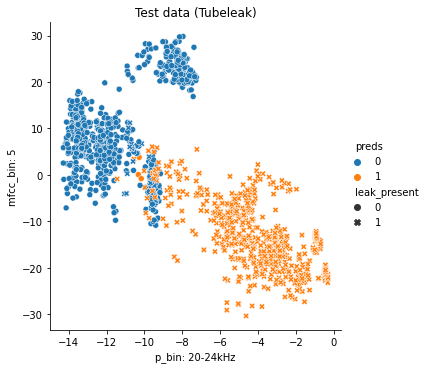

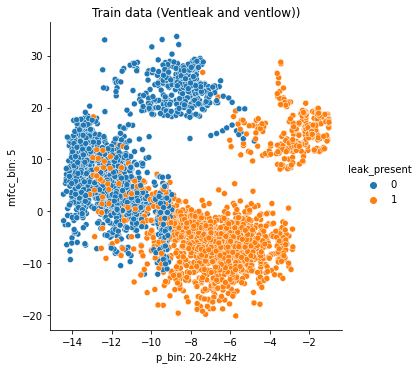

In [48]:
#NORMALIZE?
#X_test_info_preds[features] = X_test_info_preds[features] / X_test_info_preds[features].max()
#X_train_XXX[features] = X_train_XXX[features] / (X_train_XXX[features].max())

sns.relplot(data=X_test_info_preds, y=X_test_info_preds["mfcc_bin: 5"], x=X_test_info_preds["p_bin: 20-24kHz"], hue="preds", style='leak_present', height=5,  aspect=1)
plt.title("Test data (Tubeleak)")
sns.relplot(data=X_train_XXX, y=X_train_XXX["mfcc_bin: 5"], x=X_train_XXX["p_bin: 20-24kHz"], hue='leak_present', height=5,  aspect=1)
plt.title("Train data (Ventleak and ventlow))")


plt.show()


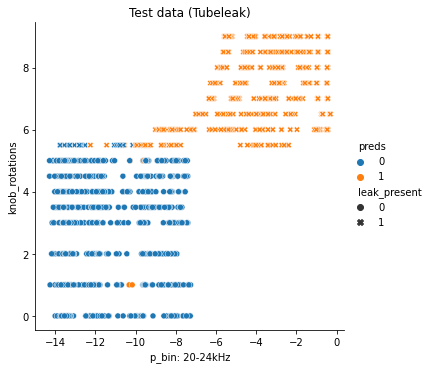

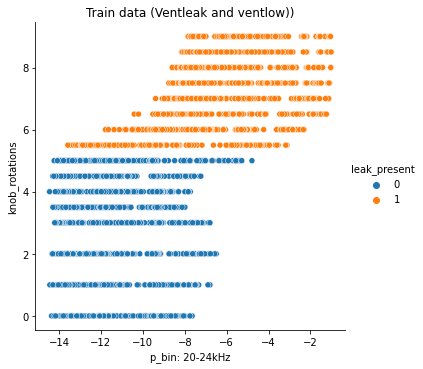

In [46]:
#X_test_info_preds[features] = X_test_info_preds[features] / X_test_info_preds[features].max()
#X_train_XXX[features] = X_train_XXX[features] / (X_train_XXX[features].max())

try: 
  X_test_info_preds['knob_rotations'] = X_test_info_preds['knob_rotations'].str.replace("n", "").apply(pd.to_numeric) #Removes 'm' and 'l' from mic and casts it to int 
  X_train_XXX['knob_rotations'] = X_train_XXX['knob_rotations'].str.replace("n", "").apply(pd.to_numeric) #Removes 'm' and 'l' from mic and casts it to int 
except: 
  pass

sns.relplot(data=X_test_info_preds, y=X_test_info_preds["knob_rotations"], x=X_test_info_preds["p_bin: 20-24kHz"], hue="preds", style='leak_present', height=5,  aspect=1)
plt.title("Test data (Tubeleak)")
sns.relplot(data=X_train_XXX, y=X_train_XXX["knob_rotations"], x=X_train_XXX["p_bin: 20-24kHz"], hue='leak_present', height=5,  aspect=1)
plt.title("Train data (Ventleak and ventlow))")

plt.show()


### E4 - different mics

[2]


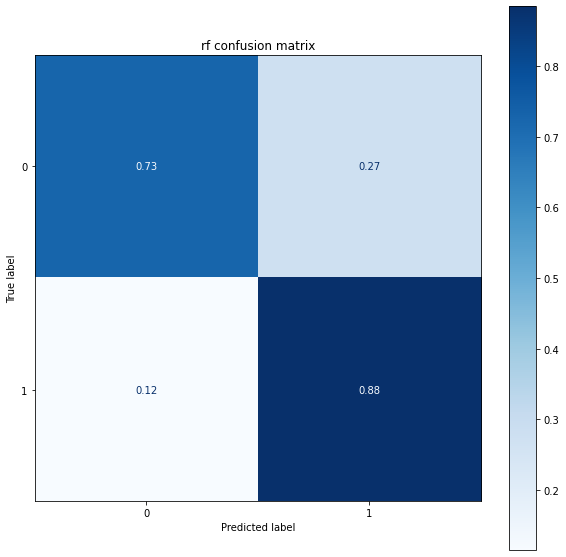

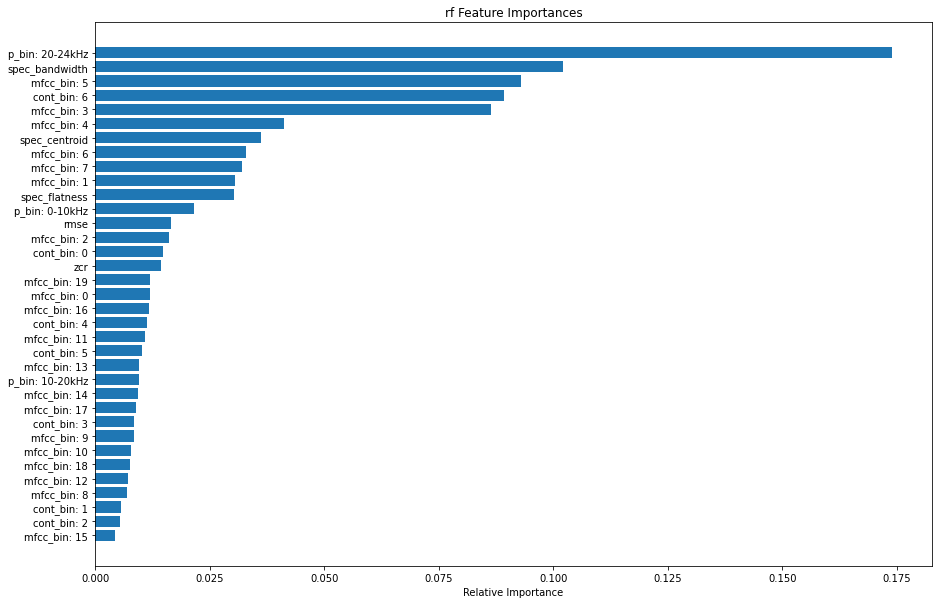

[1]


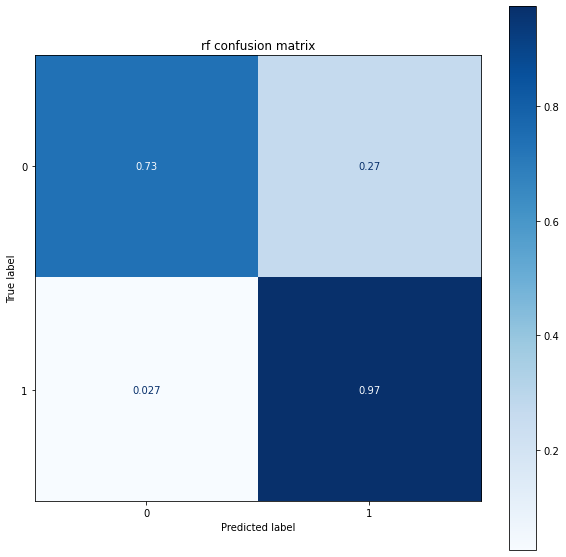

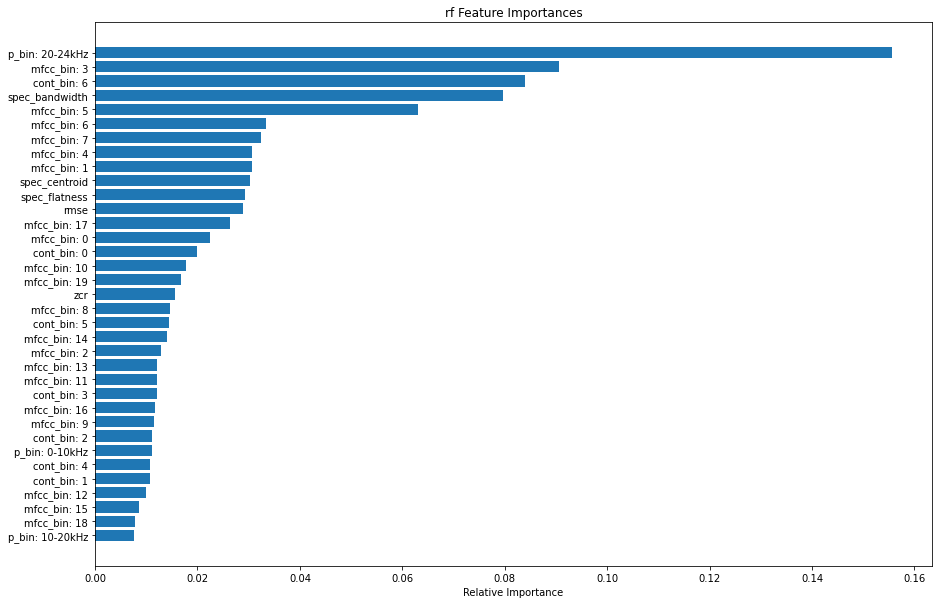

[3]


KeyboardInterrupt: ignored

In [44]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score
from itertools import combinations


X = df_train_features_E4

cv = StratifiedGroupKFold(n_splits=3)

models = untrained_ml_models()

mics = X.mic.unique()
r = len(mics) - 1
mic_combos = combinations(mics, r)

confusion = True
feature_importance = True

for combo in mic_combos:
  train = list(combo)
  test = list(set(mics) - set(train))
  print(test)
  
  all_results = {}

  #for model in models : 
  model = "rf"
  results = {}

  X_train_XXX = X.loc[X['mic'].isin(train)]
  X_test_XXX = X.loc[X['mic'].isin(test)]


  X_test_info = X_test_XXX
  X_train, y_train, X_test, y_test = get_data_labels(X_train_XXX, X_test_XXX)

  #X_train = X_train[['rp_bin: 20-24kHz', 'mfcc_bin: 4', 'spec_bandwidth', 'rp_bin: 0-10kHz']]
  #X_test = X_test[['rp_bin: 20-24kHz', 'mfcc_bin: 4', 'spec_bandwidth', 'rp_bin: 0-10kHz']]
  #X_train.drop(columns={"rp_bin: 20-24kHz", "rp_bin: 0-10kHz", "rp_bin: 10-20kHz"}, inplace=True)
  #X_test.drop(columns={"rp_bin: 20-24kHz", "rp_bin: 0-10kHz", "rp_bin: 10-20kHz"}, inplace=True)

  models[model].fit(X_train,y_train)
  score = models[model].score(X_test,y_test)
  preds = models[model].predict(X_test)

  #print("pred true: " + str(sum(preds)/len(preds)))

  pred_col = pd.DataFrame(preds)
  pred_col.columns = ["preds"]
  pred_col.reset_index(drop=True, inplace=True)
  X_test_info.reset_index(drop=True, inplace=True)
  X_test_info_preds = pd.concat([X_test_info, pred_col["preds"]], axis=1)
  aaa = X_test_info_preds

  
  features = X_train.columns
  tree_feature_importances = models[model].feature_importances_
  indices = np.argsort(tree_feature_importances)

  if confusion: 
    fig, ax = plt.subplots(figsize=(10,10))
    plt.title(model + " confusion matrix")
    disp = ConfusionMatrixDisplay.from_estimator(
        models[model],
        X_test,
        y_test,
        display_labels=[0,1],
        cmap=plt.cm.Blues,
        normalize="true",
        ax=ax) 
    plt.show()

  if feature_importance and model=="rf": 
    plt.figure(figsize=(15,10)) 
    plt.title(model + ' Feature Importances')
    plt.xlabel('Relative Importance')
    plt.barh(range(len(indices)), tree_feature_importances[indices], align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.show()

  for leak in aaa.leak_type.unique():
    for env in aaa.environment.unique():
      preds = aaa.loc[(aaa.leak_type == leak) & (aaa.environment == env)]["preds"]
      y_test = aaa.loc[(aaa.leak_type == leak) & (aaa.environment == env)]["leak_present"]
      #print(recall_score(y_test, preds, average='macro'))
      try: 
        if len(preds) != 0:
          f1 = f1_score(preds, y_test)
          acc = accuracy_score(preds, y_test)
          metric = f1 #Selecting what metric to use
        else: 
          metric = 0 
      except:
        metric =0

      key = str(leak) + " - " + env
      if key in results:
        results[key].append(metric)
      else:
        results[key] = [metric]



  
  """plt.figure(figsize=(15,10)) 
  plt.title(model + ' Feature Importances')
  plt.xlabel('Relative Importance')
  plt.barh(range(len(indices)), tree_feature_importances[indices], align='center')
  plt.yticks(range(len(indices)), [features[i] for i in indices])
  plt.show()"""
    


  average_results = {}
  for key, vals in results.items():
    if 0 in vals:
      vals.remove(0)
      average_results[key] = [np.mean(vals), "*"]
    else: 
      average_results[key] = np.mean(vals)

  all_results[model] = average_results

    #ventleak-work_low

all_results


In [ ]:
df_train_features_E4.environment.unique()

In [47]:

from itertools import combinations


X = df_train_features_E4
y = df_train_features_E4.leak_present.values 

cv = StratifiedGroupKFold(n_splits=3)
env_groups = X.recording.values

models = untrained_ml_models()

confusion = False

mics = X.mic.unique()
r = len(mics) - 1
mic_combos = combinations(mics, r)

all_results_E4 = {}

for combo in mic_combos:
  combo_results_E4 = {}
  #average_results = {}
  train = list(combo)
  test = list(set(mics) - set(train))
  #print(" ")
  #print("Mic : " + str(test[0]))
  for model in models: 
    #print(model)
    results = {}
    for train_idxs, test_idxs in cv.split(X,y,env_groups):
        #print("TRAIN:" + str(np.unique(env_groups[train_idxs])) + ", " + str(len(env_groups[train_idxs])))
        #print("TEST:" + str(np.unique(env_groups[test_idxs])) + ", " + str(len(env_groups[test_idxs])))
        X_test_info = X.iloc[test_idxs]
        X_train_XXX = X.iloc[train_idxs].loc[X['mic'].isin(train)]
        X_test_XXX = X.iloc[test_idxs].loc[X['mic'].isin(test)]
        X_test_info = X_test_XXX
        X_train, y_train, X_test, y_test = get_data_labels(X_train_XXX, X_test_XXX)


        X_train = X_train[['p_bin: 20-24kHz']]
        X_test = X_test[['p_bin: 20-24kHz']]   

        models[model].fit(X_train,y_train)
        score = models[model].score(X_test,y_test)
        preds = models[model].predict(X_test)

        print("pred true: " + str(sum(preds)/len(preds)))
        pred_col = pd.DataFrame(preds)
        pred_col.columns = ["preds"]
        pred_col.reset_index(drop=True, inplace=True)
        X_test_info.reset_index(drop=True, inplace=True)
        X_test_info_preds = pd.concat([X_test_info, pred_col["preds"]], axis=1)
        aaa = X_test_info_preds

        if confusion: 
          fig, ax = plt.subplots(figsize=(10,10))
          plt.title(model + " confusion matrix")
          disp = ConfusionMatrixDisplay.from_estimator(
              models[model],
              X_test,
              y_test,
              display_labels=[0,1],
              cmap=plt.cm.Blues,
              normalize="true",
              ax=ax) 
          plt.show()

        for leak in aaa.leak_type.unique():
          for env in aaa.environment.unique():
            preds = aaa.loc[(aaa.leak_type == leak) & (aaa.environment == env)]["preds"]
            y_test = aaa.loc[(aaa.leak_type == leak) & (aaa.environment == env)]["leak_present"]
            #print(recall_score(y_test, preds, average='macro'))
            try: 
              if len(preds) != 0:
                f1 = f1_score(preds, y_test)
                acc = accuracy_score(preds, y_test)
                metric = f1 #Selecting what metric to use
              else: 
                metric = 0 
            except:
              metric =0
            key = str(leak) + "-" + env + "-" + str(test)
            if key in results:
              results[key].append(metric)
            else:
              results[key] = [metric]
      
        #print(model)
        #print(results)


        average_results = {}
        for key, vals in results.items():
          if 0 in vals:
            #print(vals)
            vals.remove(0)
            try:
              average_results[key] = [(np.mean(vals)*100), 100*statistics.pstdev(vals), "*"]
            except: 
              average_results[key] = [0,0,"**"]
          else: 
            average_results[key] = [(np.mean(vals)*100), 100*statistics.pstdev(vals)]

    combo_results_E4[model] = average_results
  all_results_E4[str(test[0])] = combo_results_E4 

all_results_E4


pred true: 0.4528023598820059
pred true: 0.539647577092511
pred true: 0.3645066273932253
pred true: 0.28761061946902655
pred true: 0.2936857562408223


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


pred true: 0.21502209131075112


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


pred true: 0.4528023598820059
pred true: 0.539647577092511
pred true: 0.3645066273932253
pred true: 0.28761061946902655


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


pred true: 0.2936857562408223


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


pred true: 0.21502209131075112


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


pred true: 0.38495575221238937
pred true: 0.5330396475770925
pred true: 0.26730486008836524
pred true: 0.633480825958702
pred true: 0.6629955947136564
pred true: 0.5891016200294551
pred true: 0.5936578171091446
pred true: 0.630690161527166
pred true: 0.5139911634756995
pred true: 0.633480825958702
pred true: 0.6622613803230544
pred true: 0.5891016200294551
pred true: 0.5936578171091446
pred true: 0.630690161527166
pred true: 0.5139911634756995
pred true: 0.5936578171091446
pred true: 0.631424375917768
pred true: 0.5942562592047128
pred true: 0.45132743362831856
pred true: 0.5367107195301027
pred true: 0.42415316642120765
pred true: 0.35914454277286134
pred true: 0.40602055800293685
pred true: 0.33063328424153166
pred true: 0.45132743362831856
pred true: 0.5367107195301027
pred true: 0.42415316642120765
pred true: 0.35914454277286134
pred true: 0.40602055800293685
pred true: 0.35051546391752575
pred true: 0.37831858407079644
pred true: 0.4434654919236417
pred true: 0.3541973490427099


{'1': {'ada': {'tubeleak-hydr-[1]': [77.31663140769611, 0.6370281874669961],
   'tubeleak-work-[1]': [93.23998748253545, 2.2270802634724864],
   'ventleak-hydr-[1]': [80.2534640815574, 3.952947852249547],
   'ventleak-work-[1]': [97.57244840264464, 0.2934154088342033]},
  'dt': {'tubeleak-hydr-[1]': [77.89738831352332, 0.2960188254510427],
   'tubeleak-work-[1]': [84.55129855197812, 1.4191146347754473],
   'ventleak-hydr-[1]': [81.79482803138717, 2.062187405745317],
   'ventleak-work-[1]': [88.83605951047059, 1.7973429630317]},
  'dt_1': {'tubeleak-hydr-[1]': [77.31663140769611, 0.6370281874669961],
   'tubeleak-work-[1]': [93.23998748253545, 2.2270802634724864],
   'ventleak-hydr-[1]': [80.2534640815574, 3.952947852249547],
   'ventleak-work-[1]': [97.57244840264464, 0.2934154088342033]},
  'rf': {'tubeleak-hydr-[1]': [77.89738831352332, 0.2960188254510427],
   'tubeleak-work-[1]': [84.62147761622855, 1.3302867431340182],
   'ventleak-hydr-[1]': [81.79482803138717, 2.062187405745317],

### Code for storing results

In [ ]:
#Write to json
with open('all_results_E1_only1feat.json', 'w') as outfile:
    json.dump(all_results, outfile)
  
#Read from json
with open('all_results_E1_only1feat.json') as json_file:
    data = json.load(json_file)

#### E1

In [ ]:
env_order = ["lab", "work_low", "work", "hydr_low", "hydr"]
leak_order = ["ventleak", "ventlow", "tubeleak"]
models = ["dt", "rf", "ada", "xgb"]

data = all_results_E1


verbose = False
for model in models: 
  print(model)
  for env in env_order: 
    sum = []
    for leak in leak_order: 
      #for key in data: 
        for info in data[model]: 
          a = info.split("-")[0]
          b = info.split("-")[-1]
          if a == leak and b == env:
            if len(data[model][info]) == 3 and verbose: 
              print("* below?")
            else:
              acc = data[model][info][0]
              res = data[model][info][1]
              acc_short = float(str(acc)[:5]) 
              res_short = float(str(res)[:4]) 
              sum.append(acc)
            #  #print("alert below") 
              
        if verbose: 
          print(leak + ", " + env + ": " + str(acc_short) + "," + str(res_short))
        else: 
          print(str(acc_short) + "," + str(res_short))
    if verbose: 
      print("Average " + env + ": " + str(np.mean(sum))[:5] + "," + str(statistics.pstdev(sum))[:5])
    else: 
      print(str(np.mean(sum))[:5] + "," + str(statistics.pstdev(sum))[:4])

  print("_________________")

dt
98.57,1.52
95.75,3.02
97.04,1.68
97.12,1.15
95.25,0.6
90.7,3.26
93.92,1.7
93.29,1.90
95.69,1.34
93.38,1.98
92.7,1.39
93.92,1.27
96.72,1.28
91.83,0.98
91.73,1.44
93.43,2.32
93.31,0.56
89.46,1.33
88.33,0.9
90.37,2.13
_________________
rf
99.86,0.18
97.44,2.46
97.73,2.37
98.34,1.08
98.66,1.33
94.06,0.29
97.01,1.5
96.58,1.90
99.12,0.47
95.84,2.52
95.85,2.72
96.94,1.54
98.71,0.77
94.72,1.1
96.06,0.76
96.49,1.65
95.69,1.78
94.73,1.4
92.84,1.32
94.42,1.18
_________________
ada
100.0,0.0
97.64,2.53
98.12,1.81
98.58,1.01
98.22,1.77
93.86,0.2
95.81,1.2
95.96,1.78
98.53,1.09
95.45,2.49
94.86,3.25
96.28,1.61
96.13,0.72
93.72,0.5
93.2,0.46
94.35,1.27
93.6,0.77
93.06,2.27
89.41,0.48
92.02,1.86
_________________
xgb
99.9,0.14
96.94,2.4
97.82,2.23
98.22,1.23
98.81,1.18
94.26,0.53
96.41,1.44
96.49,1.85
99.02,0.73
95.25,2.12
95.85,2.51
96.71,1.65
98.21,0.25
94.32,0.65
95.57,0.63
96.03,1.62
95.6,1.84
94.74,1.37
92.54,2.23
94.29,1.28
_________________


#### E2

In [ ]:
data = all_results_E2
leak_order = ["ventleak", "ventlow", "tubeleak"]


verbose = False
for model in data.keys(): 
  print(model)
  sum = []
  for leak in leak_order: 
    #for key in data: 
      for info in data[model]: 
        a_leak = info.split("-")[0]
        b_env = info.split("-")[-1]
        if a_leak == leak:
          if len(data[model][info]) == 3 and verbose: 
            print("* below?")
          else:
            acc = data[model][info][0]
            res = data[model][info][1]
            acc_short = float(str(acc)[:5]) 
            res_short = float(str(res)[:4]) 
            sum.append(acc)
          #  #print("alert below") 
            
      if verbose: 
        print(leak + ", " + b_env + ": " + str(acc_short) + "," + str(res_short))
      else: 
        print(str(acc_short) + "," + str(res_short))
  if verbose: 
    print("Average " + b_env + ": " + str(np.mean(sum))[:5] + "," + str(statistics.pstdev(sum))[:5])
  else: 
    print(str(np.mean(sum))[:5] + "," + str(statistics.pstdev(sum))[:4])

  print("_________________")

dt
76.0,6.59
75.97,6.82
75.19,5.29
75.72,0.37
_________________
dt_1
72.28,0.8
73.06,1.37
71.76,0.24
72.37,0.53
_________________
rf
72.09,0.53
72.86,1.09
71.76,0.0
72.24,0.46
_________________
ada
72.09,0.53
73.17,1.52
71.96,0.13
72.40,0.54
_________________
xgb
72.29,0.4
73.27,1.66
71.96,0.13
72.50,0.55
_________________


#### E3

In [54]:
env_order = ["lab", "work_low", "work", "hydr_low", "hydr"]
data = all_results_E3
test_leak = "tubeleak"

print("Results: E3")
print("___________")
verbose = False
for model in data.keys(): 
  print(model)
  sum = []
  for env in env_order: 
    #for key in data: 
      for info in data[model]: 
        a_leak = info.split("-")[0]
        b_env = info.split("-")[-1]
        if b_env == env:
          if len(data[model][info]) == 3 and verbose: 
            print("* below?")
          acc = data[model][info][0]
          res = data[model][info][1]
          acc_short = float(str(acc)[:5]) 
          res_short = float(str(res)[:4]) 
          sum.append(acc)
        #  #print("alert below") 
            
      if verbose: 
        print(leak + ", " + env + ": " + str(acc_short) + "," + str(res_short))
      else: 
        print(str(acc_short) + "," + str(res_short))
  if verbose: 
    print("Average " + env + ": " + str(np.mean(sum))[:5] + "," + str(statistics.pstdev(sum))[:5])
  else: 
    print(str(np.mean(sum))[:5] + "," + str(statistics.pstdev(sum))[:4])

  print("_________________")

Results: E3
___________
dt
91.33,6.8
88.27,0.36
90.51,3.52
52.82,26.1
52.89,15.5
75.17,18.2
_________________
dt_1
70.84,6.47
67.82,0.48
79.73,9.01
93.43,0.87
74.97,1.29
77.36,8.97
_________________
rf
94.48,3.19
95.96,3.12
94.95,2.56
95.41,1.11
87.86,2.56
93.73,2.97
_________________
ada
89.84,10.2
91.55,2.99
92.6,2.35
90.77,1.44
83.4,2.78
89.63,3.24
_________________
xgb
93.32,5.3
94.96,2.93
94.63,1.79
95.54,0.58
83.66,3.5
92.42,4.44
_________________


#### E4

In [ ]:
all_results_E4

In [48]:
env_order = ["work", "hydr"]
leak_order = ["ventleak", "tubeleak"]

data = all_results_E4

print("Results: E4")
print("___________")
verbose = False
for mic_test in data.keys():
  print(mic_test)
  print("- - - -")
  for model in data[mic_test].keys(): 
    print(model)
    sum = []
    for env in env_order: 
      #sum = []
      for leak in leak_order: 
        #for key in data: 
          for info in data[mic_test][model]: 
            a = info.split("-")[0]
            b = info.split("-")[1]
            if a == leak and b == env:
              if len(data[mic_test][model][info]) == 3 and verbose: 
                print("* below?")
              else:
                acc = data[mic_test][model][info][0]
                res = data[mic_test][model][info][1]
                acc_short = float(str(acc)[:5]) 
                res_short = float(str(res)[:4]) 
                sum.append(acc)
                #print("alert below") 
          if verbose: 
            print(leak + ", " + env + ": " + str(acc_short) + "," + str(res_short))
          else: 
            print(str(acc_short) + "," + str(res_short))
    if verbose: 
      try: 
        print("Average mic: " + mic_test + ": " + str(np.mean(sum))[:5] + "," + str(statistics.pstdev(sum))[:5])
      except: 
        print(0, "FIRST FLOOW")
    else: 
      try: 
        print(str(np.mean(sum))[:5] + "," + str(statistics.pstdev(sum))[:4])
      except: 
        print(0, "SECOND FLOOR")

    print("_________________")

Results: E4
___________
2
- - - -
dt
84.94,2.08
64.5,7.33
80.81,3.16
39.9,5.96
67.54,17.6
_________________
dt_1
94.96,3.38
58.83,24.7
84.32,1.4
0.0,0.0
59.53,36.7
_________________
rf
84.94,2.08
64.5,7.33
80.81,3.16
39.9,5.96
67.54,17.6
_________________
ada
94.96,3.38
58.83,24.7
84.32,1.4
0.0,0.0
59.53,36.7
_________________
xgb
88.6,2.72
65.02,8.73
84.57,5.02
33.19,14.3
67.84,21.9
_________________
1
- - - -
dt
88.83,1.79
84.55,1.41
81.79,2.06
77.89,0.29
83.26,3.98
_________________
dt_1
97.57,0.29
93.23,2.22
80.25,3.95
77.31,0.63
87.09,8.51
_________________
rf
88.83,1.79
84.62,1.33
81.79,2.06
77.89,0.29
83.28,3.99
_________________
ada
97.57,0.29
93.23,2.22
80.25,3.95
77.31,0.63
87.09,8.51
_________________
xgb
97.79,0.26
93.74,1.36
77.2,0.64
77.04,0.25
86.44,9.43
_________________
3
- - - -
dt
89.78,1.78
82.01,2.89
90.71,0.85
66.4,7.32
82.22,9.74
_________________
dt_1
97.07,2.17
86.63,5.29
92.39,1.05
50.25,14.5
81.58,18.4
_________________
rf
89.78,1.78
82.01,2.89
90.71,0.85
66.